## 第四章
* 前面的线性神经网络可以说是所有网络的基础，但它本身的表达能力非常有限，真正的深度网络一定需要具备拟合非线性关系的能力，因此本章引入了最简单的深度网络：**多层感知机(MLP)** 
* 多层感知机作为深度网络的一种，会遇到很多深度模型都会遇到的问题，例如过拟合和欠拟合、模型选择、正则化技术、计算性能效率等，因此以多层感知机为例，这一章也会关心这些基本问题

### 4.1 多层感知机的简单介绍

* 这里d2l用了很大的篇幅来介绍MLP，这里对文字部分做一个简短且深刻的总结：    
    首先线性模型的表达能力非常有限，单个特征只能正向或者负向线性地影响观测数据的变化，但这在现实生活中是很难见到的，一般的模式识别任务都会有非线性的情况，需要更为复杂的网络来表示，比如我们之前的softmax用多个像素的像素值强度来映射到分类类别，这本身就具有一定的局限性  
    所以解决办法是什么呢？很简单，我们只需要在网络中加上一些隐藏层，但光加隐藏层还不行，我们用下面的公式来表示，$\mathbf{X} \in\mathbb{R}^{n \times d}$表示n个样本的小批量，每个样本具有d个输入特征；单隐藏层的多层感知机的中间层可以表示为
    $\mathbf{H} \in \mathbb{R}^{n\times h}$,其中h表示隐藏单元的个数，
    $\mathbf{H}$ 也被称为隐藏层变量或隐藏变量，我们再假定这个单隐藏层的多层感知机的输出为
    $\mathbf{O} \in \mathbb{R}^{n\times q}$,这样我们可以将多层感知机的处理表示为：
    $$
        \mathbf{H} = \mathbf{X}\mathbf{W}^{(1)} + \mathbf{b}^{(1)} \\
        \mathbf{O} = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}
    $$
    上述的模型中没有任何进步的地方，原因在于隐藏单元由输入的仿射函数给出，而输出只是隐藏单元的仿射函数，仿射函数的仿射函数还是仿射函数，换句话说，通过上述这样设计的多层感知机能做到的线性映射，没有隐藏层的常规单层输入-输出模型也完全可以做到！  
    所以既然采用了这样的多层结构，就一定要对内部做一定的改进，多层感知的关键要素在于：**在仿射变换之后对每个隐藏单元应用非线性的激活函数(activation function)$\sigma$**，自然由激活函数处理后的输出被称为**活性值(activations)**。引入了激活函数之后，多层感知机变成下面的样子：
    $$
        \mathbf{H} = \sigma{(\mathbf{X}\mathbf{W}^{(1)} + \mathbf{b}^{(1)})} \\
        \mathbf{O} = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}
    $$

    多层感知机的设计有其遵循的数学原理————通用近似定理，多层感知机是通用近似器，即便网络只有一个隐藏层，在给定足够的神经元和正确的权重后，这个简单的多层感知机也可以对任意函数建模。虽然一个单隐藏层的网络理论上可以学习任何函数，但在实际情况下仍然不能指望单隐藏层的网络去解决所有问题

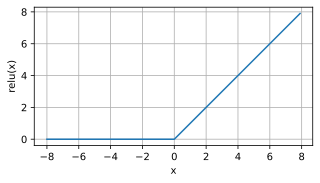

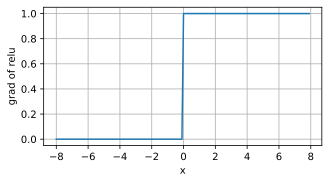

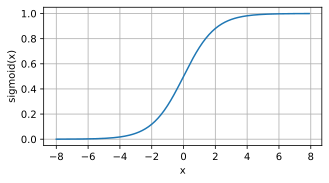

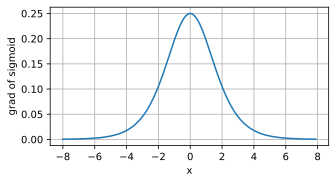

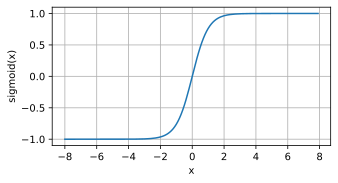

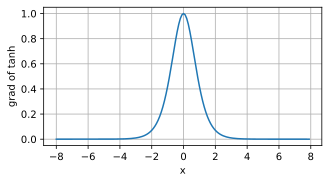

In [27]:
# 既然多层感知机相较于最基础的线性网络的最大区别在于激活函数的引入，那么本节主要介绍几个常用的激活函数的效果
import torch
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

# 使用之前定义的plot函数
def use_display():
    backend_inline.set_matplotlib_formats("svg")
# backend_inline是IPython库的一个模块，主要作用是控制matplotlib图表的显示方式，设置的"svg"是一种矢量图格式，svg是一种基于XML的矢量图形格式，与"png"等位图格式不同，矢量图形格式可以做到无损缩放，但渲染复杂图形时消耗资源更多

def set_figsize(figsize = [3.5,2.5]):
    use_display()
    plt.rcParams["figure.figsize"] = figsize


def set_axes(axes,xlabel,ylabel,xscale,yscale,xlim,ylim,legend=None):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.grid()
    if legend:
        axes.legend(legend)

# 上述的所有格式设置都是为了下面的plot函数服务，plot函数考虑了这样几种情况：只有y轴方向的数据，这意味着x轴坐标可能不重要，默认赋值为[0,n-1];在相同的x轴取值下，同时画出多条函数曲线

def plot(X, Y=None, xlabel=None, ylabel=None, xscale='linear', yscale='linear', xlim=None, ylim=None, fmts=('-','m--','g-.','r:'), figsize=(3.5,2.5), axes=None, legend=None):
    # fmts中指定了四种绘图格式，默认的plot曲线颜色为蓝色，'-'也是默认格式，表示实线，‘--’表示虚线，‘-.’表示点划线，':'表示点线
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca() # 未指定特定的绘图axes就选择当前的axes

    def has_oneaxis(x):
        if hasattr(x,"ndim") and x.ndim == 1 or isinstance(x,list) and not hasattr(x[0],"__len__"):
            return True
    # 这里的函数判断了两类情况，首先如果不是普通的list，那指定ndim==1确定了只会是一维的计算单元；如果是list类型，则x[0]没有'__len__'使得也不会出现二维以上的多维情况

    if has_oneaxis(X):
        X = [X] # 不管在调用plot函数时有没有指定y，这样的操作都会在原来的x基础上再套一个[],使得原来一维的计算单元变成了[1,n]这样的结构，这样的主要原因是为了配合后面的多组同时绘制

    if Y is None:
        X, Y = [[]] * len(X), X # 主要是为了处理未指定Y的情况,首先会执行将X的值赋给Y，再将X设置为对应长度的[]，这里设置对应长度主要是为了配合zip的解包
    elif has_oneaxis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()

    for x,y,fmt in zip(X,Y,fmts):
        if len(x):
            plt.plot(x,y,fmt)
        else:
            plt.plot(y,fmt)
    
    set_axes(axes,xlabel,ylabel,xscale,yscale,xlim,ylim,legend)

# 首先是最常用的RELU激活函数
x = torch.arange(-8.0,8.0,0.1, requires_grad=True) # 前闭后开
y = torch.relu(x)
plot(x.detach(),y.detach(),"x","relu(x)",figsize=(5,2.5))
plt.show()
# 输入为负时，RELU会将输入输出为0，当输入为正时，RELU保留原来的输入值
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(),x.grad,"x","grad of relu",figsize = (5,2.5))
plt.show()
# d2l这里介绍了RELU的变种，RELU的变种有非常多，完全可以不用特别留心记忆，遇到一些特别的再留个印象即可

# 接下来是也比较常见的sigmoid激活函数
y = torch.sigmoid(x)
plot(x.detach(),y.detach(),"x","sigmoid(x)",figsize=(5,2.5))
plt.show()
x.grad.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(),x.grad,"x","grad of sigmoid",figsize=(5,2.5))
plt.show()

# 最后是和sigmoid类似的tanh激活函数，这个激活函数同样也是二分类的，区别在于tanh将两头放在了-1和1，而不是sigmoid的0和1
y = torch.tanh(x)
plot(x.detach(),y.detach(),"x","sigmoid(x)",figsize=(5,2.5))
plt.show()
x.grad.zero_()
y.backward(torch.ones_like(x))
plot(x.detach(),x.grad,"x","grad of tanh",figsize=(5,2.5))
plt.show()

- 这里添加一个markdown的说明，主要为了说明三种常见的激活函数的数学表达形式

- RELU激活函数的数学形式：
$$
    \mathbf{ReLU}(x) = \mathbf{max}(x,0)
$$

- sigmoid激活函数的数学形式：
$$
    \mathbf{sigmoid}(x) = \frac{1}{1+e^{-x}}
$$

- tanh激活函数的数学形式：
$$
    \mathbf{tanh}(x) = \frac{1-\mathbf{exp}(-2x)}{1+\mathbf{exp}(-2x)}
$$

### 4.2 多层感知机的从零开始实现

In [4]:
# 从零实现多层感知机需要用到第三章的训练函数
# 接下来正式从零开始，主要包括初始化模型参数、定义softmax、定义模型、定义损失函数、描述分类精度、训练函数、绘图函数、预测函数等等
import torch
import torchvision
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from torch.utils import data
from torchvision import transforms

# 当输出的概率中最大的那个实际上就是网络判断的预测类别，因此既然有真实类别和预测类别，自然就会有分类是否正确的问题，所以在这个示例中也定义一个计算分类精度的
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1 and len(y_hat.shape) > 1:
        y_hat = y_hat.argmax(axis=1) # torch.tensor的方法
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# 定义一个实用类，用于记录一些变量并完成累加操作
class Accumulator:
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data,args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]
    
# 在Accumulator类的基础上定义记录预测精度的函数
def evaluate_accuracy(net, data_iter):
    '''Accumulator实例中第一个记录的是预测正确的样本数 第二个记录的是总的样本数'''
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return (metric[0] / metric[1])

# 接下来定义训练的专用函数
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric = Accumulator(3) # Accumulator实例中有三个变量，第一个记录单次epoch中所有的loss和，第二个记录预测正确的样本数，第三个记录总的样本数
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward() # 这里传入sum()的主要原因是我们自定义的sgd是除了一个batch_size的，并且sgd函数中有梯度清零的操作
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2], metric[1]/metric[2]

# 这里有一个在d2l包中定义的绘制专用类，可以直接用现成的，也可以重新在这里定义
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.grid()
    if legend:
        axes.legend(legend)

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None,
                 xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                 figsize=(3.5,2.5)):
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda:set_axes(
            self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend
        )
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self,x,y):
        if not hasattr(y,"__len__"):
            y = [y]
        n = len(y)
        if  not hasattr(x,"__len__"):
            x = [x] * n
        # self.X和self.Y这两个类其实是为了画出loss和在训练集和测试集上随着训练epoch的变化情况，因此长度就是3
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y,fmt in zip(self.X,self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes() # 灵活运用lambda函数省去重复使用复杂函数
        display.display(self.fig)
        display.clear_output(wait=True) # display这个模块的引入主要是为了动态画出变化的过程 直接plot + show 无法实现这种动态变化的效果

# 上面的绘画类实际上画出的是多个epoch之间的变化情况，因此在实现单次训练迭代的基础上定义总的训练函数

def train_ch3(net, train_iter, test_iter, loss ,num_epochs, updater):
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,1.0],legend=["train loss", 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <=1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc # 判断一下特殊情况

# 训练完成后，我们可以运用训练结束的网络进行预测，这里用到了前面的显示图片和类别的函数

def show_labels(labels):
    name_labels = ['t-shirt','trousers','pullover','dress','coat','sandel','shirt','sneaker','bag','ankle boot']
    return [name_labels[int(i)] for i in labels] # 要写int 不然不能正确索引

def show_images(images,num_rows,num_cols,scale=1.5,labels=None):
    figure_size = [num_cols*scale,num_rows*scale]
    _,axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figure_size)
    axes = axes.flatten()
    for i,(axe,image) in enumerate(zip(axes,images)):
        if torch.is_tensor(image):
            axe.imshow(image.numpy())
        else:
            axe.imshow(image)
        axe.axes.get_xaxis().set_visible(False)
        axe.axes.get_yaxis().set_visible(False)
        if labels:
            axe.set_title(labels[i])

def predict_ch3(net, test_iter, n=6):
    for X,y in test_iter:
        break
    trues = show_labels(y)
    preds = show_labels(net(X).argmax(axis=1))
    titles = [true+"\n"+pred for true,pred in zip(trues,preds)]
    show_images(X.squeeze(),1,n,labels=titles[0:n])


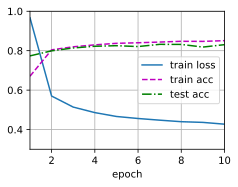

In [19]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import torch.nn as nn

batch_size = 256
# 使用在第三章的数据集定义函数
def load_data_fashion_mnist(batch_size,resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",download=False,transform=trans,train=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",download=False,transform=trans,train=False)
    return data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True),data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True)

train_iter, test_iter = load_data_fashion_mnist(batch_size)

# 这里选择单隐藏层的多层感知机，隐藏层的节点个数为256
num_inputs, num_outputs, num_hidden = 784, 10, 256
W1 = nn.Parameter(torch.randn((num_inputs,num_hidden),requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hidden,requires_grad=True))
W2 = nn.Parameter(torch.randn((num_hidden,num_outputs),requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

def relu(x):
    a = torch.zeros_like(x)
    return torch.max(a,x)

def net(X):
    X = X.reshape((-1,num_inputs))
    y1 = X @ W1 + b1
    return (y1 @ W2 + b2)

loss = nn.CrossEntropyLoss(reduction="none")

num_epochs = 10
lr = 0.1
updater = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)


#### 4.3 多层感知机的简洁实现

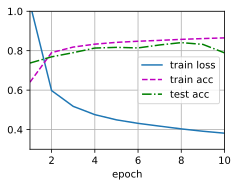

In [7]:
# 上面的从零实现其实不是真正意义上的from scratch，省略的原因在于很多从零实现的代码比如优化器、损失函数等都在第三章实现过，因此从零实现的也就只有网络部分
# 简洁实现的主要区别就是网络结构由torch.nn实现
import torch.nn as nn
import torch

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
    '''其实这个初始化参数不是很有必要，原因在于pytorch其实会选择比较适当的例如kaiming初始化等来处理网络参数'''
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights) # 网络参数的初始化方式
batch_size = 256
lr = 0.1
num_epochs = 10

loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(),lr = lr)

train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

### 4.4 模型选择、欠拟合和过拟合

- 过拟合和欠拟合的概念其实很好理解，模型在训练数据上过度训练导致在训练分布偏离实际分布的现象称为过拟合，而欠拟合则是尚未通过训练数据发掘解决问题的模式。
- d2l一书中对过拟合和欠拟合展开了一系列的论述，此外还提到了对抗过拟合的技术即为**正则化**，下面对这些内容做一个总结性的论述：  

    首先是**训练误差**和**泛化误差**的概念，训练误差指的是模型在训练集得到的误差，而泛化误差指的是模型在遵从于原始分布的无限多数据样本时的误差，从概念上讲泛化误差是无法得到的，但我们通常会用一个独立测试集近似获得泛化误差。之后提到了独立同分布假设
    **(i.i.d. assumption)**，即训练数据和测试数据遵从于相同的分布独立提取得到，独立同分布假设其实在众多的场景下都无法满足，但我们假定在轻微违背的情况下模型仍能运行得很好。这里还提到了**模型复杂性**的问题，例如我们有一个简单的模型和大量的数据，此时泛化误差和训练误差会非常接近，因为简单的模型表达能力不强，即使在训练集训练情况也不佳；但如果我们有一个复杂的模型和少量的数据，此时在训练集上由于强大的模型拟合能力致使训练集损失极小，但由于少量数据无法代表真实分布，泛化误差会增大。上述讨论的一个关键在于如何定义**模型的复杂程度**，你可以用更多参数来衡量，也可以用参数的取值范围大小来衡量，甚至可以通过模型的训练迭代次数来衡量。因此文章给出一个比较通俗且被大家认可的观点：**能够轻松介绍任意事实的模型是复杂的，而表达能力有限但仍能很好地解释数据的模型可能更有现实用途**  

    机器学习中一个很关键的环节是**模型选择**，比如我们可能需要在多个模型结构中做出抉择，也可能在统一模型架构的情况下需要选择合适的超参数设置。为了确定一众候选模型中的最佳模型，我们通常会使用**验证集**。之前的一些代码示例中，我们只将数据简单的分为了训练集+测试集，比方说我们现在有一个需要确认超参数设置的场景，我们肯定不希望在选择模型的过程中使用到测试集，请注意这里讨论的背景，如果你现在这几个模型都可以同时使用且测试集数据握在你自己手上，你当然可以直接在测试集上测试，然后选择最好的模型；但我们应该考虑这样的场景：你是无法获得真实的测试数据集，因此你被迫的需要分出部分数据进行模型选择的测试，所以这里我们引入验证集。d2l书中提到验证集和测试集的边界非常模糊，甚至在这本书里，我们通常将数据分为训练集+测试集，其实这里的测试集更符合我们真正定义中的验证集。当训练数据稀缺时，我们可能没办法提供足够的数据构建一个验证集，常见的做法是**K折交叉验证**：将原始训练数据分为K个不重叠的子集，然后执行K次下面的实验：每次在(K-1)个子集上进行训练，并在生育的一个子集上进行验证，最后我们会对K次实验中的结果取平均来衡量训练误差和验证误差。

    根据我们之前关于模型复杂度的讨论，我们继续深入讨论一下：前面我们提到**模型的复杂程度**和**数据集大小**是决定模型训练是否过拟合和欠拟合的重点：我们先讨论数据集大小，数据集过小在训练时越容易过拟合，因此在深度学习中对于数据集的大小有明确的需求，文中也提到目前深度学习的发展要归功于廉价存储、互联设备和数字化经济带来的海量数据集；其次是模型复杂度，关于模型复杂度和训练效果的关系，我们首先用下面的曲线来说明：
    ![模型复杂度和训练效果的关系](./images/chapter4/1.png)
    **下面的一个Python窗口显示了如何用多项式拟合来说明**模型复杂度，我们先用文字和图片来说明。我们希望用一个
    $\mathbf{d}$ 阶多项式来估计标签数据，即：
    $$ 
        \hat{y} = \sum_{i=0}^{d} x^{i}w_{i}
    $$
    可以想象上面的公式中类似于一个网络模型，网络权重由
    $w_{i}$给出，而偏置由
    $w_{0}$给出，既然多项式是一个模型，那么我们可以得到的无需推导的结论就是：高阶多项式函数比低阶多项式函数更复杂，原因在于高阶多项式的参数更多，模型函数的选择范围更广。我们可以用不同的阶数模型来说明过拟合和欠拟合的情况：不同阶数的函数模型作为网络模型，我们首先需要定义一个在该网络上训练的数据集，数据集我们选择三阶多项式：
    $$
        y = 5 + 1.2x - 3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\epsilon\quad where \epsilon\sim \mathcal{N}(0,0.1^2)
    $$


weight: [[ 5.002851   1.2462935 -3.3787985  5.5191917]]


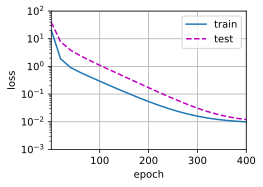

In [ ]:
import math
import numpy as np
import torch
from torch.utils import data
import torch.nn as nn

max_degree = 20
n_train, n_test = 100, 100
true_w = torch.zeros(max_degree)
true_w[0:4] = torch.tensor([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1)) # 利用广播机制计算的除去阶乘的n次方项
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # gamma(n) = (n-1)!
print(poly_features.shape)
labels = np.dot(poly_features,true_w) # 等同于np.matmul()
labels += np.random.normal(scale=0.1, size=labels.shape) # 注意用法
print(labels.shape)

# 定义一个函数来衡量在数据集上的损失
def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y) # 注意我们之前自定义的loss函数，都是把网络输出放在第一个参数的位置，真实的标签数据放在第二个参数的位置，目的就是为了与torch中封装的loss匹配
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

def load_array(array,batch_size,shuffle=True):
    data_set = data.TensorDataset(*array)
    return data.DataLoader(data_set,batch_size=batch_size,shuffle=shuffle)

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction="none")
    input_shape = train_features.shape[-1] # 这里的总计20个阶数我们不会全部都用，原因就是20个的范围是用来定义不同复杂程度的模型的，因此我们喂入的输入维度会在后面的对比实验中进行调整，所以我们也没有在外面直接定义网络形状
    net = nn.Sequential(nn.Linear(input_shape,1,bias=False)) # 本身就有一个维度是表示常数偏置
    batch_size = min(10,train_labels.shape[0])
    train_iter = load_array((train_features,train_labels.reshape(-1,1)),batch_size) # 注意labels和features的形状要对齐
    test_iter = load_array((test_features,test_labels.reshape(-1,1)),batch_size,shuffle=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = Animator(xlabel="epoch",ylabel='loss',yscale="log",xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch == 0 or (epoch+1) % 20 == 0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:', net[0].weight.data.numpy())

# 我们在下面的几个的模型中测试上述训练函数，通过调整阶数的多少来调整模型的复杂程度

# 3阶的多项式函数，取前四个，此时是最符合真实的数据分布的模型
# train(poly_features[:n_train, :4], poly_features[n_train:,:4],labels[:n_train],labels[n_train:])
train(torch.tensor(poly_features[:n_train, :4],dtype=torch.float32), torch.tensor(poly_features[n_train:,:4],dtype=torch.float32),torch.tensor(labels[:n_train],dtype=torch.float32),torch.tensor(labels[n_train:],dtype=torch.float32))

weight: [[3.6863663 3.3998349]]


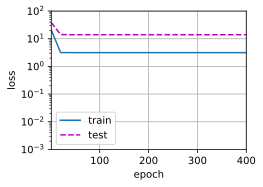

In [46]:
# 1阶的多项式函数，取前两个，此时模型复杂程度不够，会导致训练欠拟合
train(torch.tensor(poly_features[:n_train, :2],dtype=torch.float32), torch.tensor(poly_features[n_train:,:2],dtype=torch.float32),torch.tensor(labels[:n_train],dtype=torch.float32),torch.tensor(labels[n_train:],dtype=torch.float32))


weight: [[ 5.023314    1.345254   -3.490566    4.99165     0.1897928   1.2798505
   0.42139778  0.13586704 -0.11859385  0.09536216 -0.05610691  0.06749827
   0.15992364  0.02461294 -0.2153958  -0.06160734  0.1868193  -0.0569267
  -0.0969689   0.05851378]]


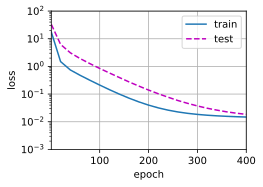

In [47]:
# 19阶的多项式函数，取所有的20个，此时模型复杂程度太高，在少量数据上会出现过拟合的现象，反而在测试集上表现不好
train(torch.tensor(poly_features[:n_train, :],dtype=torch.float32), torch.tensor(poly_features[n_train:,:],dtype=torch.float32),torch.tensor(labels[:n_train],dtype=torch.float32),torch.tensor(labels[n_train:],dtype=torch.float32))

### 4.5 权重衰减

- 上一节用多项式作为网络模型分析了过拟合和欠拟合的现象，之前提到了可以**用正则化的方法缓解过拟合的问题**。从这一节开始，会介绍一些正则化方法，这一节主要围绕的是**权重衰减(weight decay)**
- d2l这里提到了上一节多项式的例子，多项式中我们是通过调整多项式的阶数来限制模型的容量，可以理解成：限制特征数量是缓解过拟合的一种常用技术，但如果仅仅是限制特征数量，有点太暴力了(原因是阶数发生微小的改变，可能会致使特征数量出现骤增或骤减的现象，拿多项式举例，给定k个变量的情况下，阶数为d的项的个数为
$\mathbf{C}_{k-1+d}^{k-1}$,只要稍微改变d，总共的阶数就会发生巨大的改变)，因此需要一种更细粒度的技术来度量模型复杂性
- 权重衰减也被称为**L2正则化**，如果我们说一个函数
$\mathcal{f} = 0$,从某种数值的角度上来说，此时函数是最简单的，原因是无论自变量如果取值，函数最终只输出0无任何特征信息，因此可以通过计算此时模型表示的函数
$\mathcal{f}$和零函数的距离来衡量函数的复杂度，具体来说，例如在
$f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}$ 的线性函数中，可以用
$||\mathbf{w}||^2$来度量网络的复杂度，此时为了让这一项起到作用，真正地惩罚太大的权重向量，我们可以将惩罚项写入损失函数之中，即
$$
\mathbf{\mathit{L}}(\mathbf{w},x) + \frac{\lambda}{2}||\mathbf{w}||^2
$$  
- 这里关于正则项有几个需要说明的地方，之所以用L2范数而不用L1范数的原因在于L2更适合惩罚那些较大的权重，L1更适合将一些较小的权重变为0，可以从这个效果上来说，L1范数其实是在做一些特征筛选，因此L2更适合在权重衰减的背景下使用，我们如果将网络结局的问题看成是一个矩阵乘法+偏置的线性问题，此时我们可以分析一下每次权重是如何变化的：
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta\lambda \mathbf{w}_{t} - \frac{\eta}{|\mathbf{B}|}\sum_{i\in B}\mathbf{x}^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)} + b - y^{(i)})
$$  
上述参数更新的公式就是计算新的损失函数得到的，可以从这里看到为什么对模型参数做L2正则化可以称为权重衰减，其实就是如果不考虑数据保真项对参数的调整的情况时，正则化项对参数的影响其实就是在慢慢变小的，这就是被称为衰减的原因
- 这里围绕权重衰减展开说一下，这里的正则化项是在处理参数和模型的复杂程度，是在解决过拟合的问题，这和网络可能本身要解决的正逆问题中的正则项关系不大，这一点需要结合使用场景来理解
- 可能有些人会担心一点：既然说这样的正则化其实是在做权重衰减，那会不会在优化到比较大的迭代次数时，权重衰减的效果使得所有的权重都回退到接近0的水平，其实不需要有这个担忧，原因就是数据保真项的梯度会把权重往另外的方向拉，最终在迭代到收敛的时候两部分损失函数会将权重拉到一个比较稳定的范围，参数本身数值不会很大，同时也会让损失函数尽可能小

w的L2范数是： 13.815885543823242


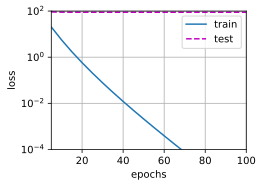

In [8]:
# 利用在这一章定义的一些函数来测试一下权重衰减的效果，先是从零开始实现权重衰减

import torch
import torch.nn as nn
from torch.utils import data

n_train, n_test, num_inputs, batch_size = 20,100,200,5
true_w, true_b = torch.ones((num_inputs,1)) * 0.01, 0.05

def syn_data(w,b,data_len):
    x = torch.normal(0,1,(data_len,len(w)))
    y = torch.mm(x,w) + b
    y -= torch.normal(0,0.01,y.shape)
    return x,y.reshape(-1,1)

def load_array(array,batch_size,shuffle=True):
    data_set = data.TensorDataset(*array)
    return data.DataLoader(data_set,batch_size=batch_size,shuffle=shuffle)

train_data = syn_data(true_w,true_b,n_train)
train_iter = load_array(train_data, batch_size)
test_data = syn_data(true_w,true_b,n_test)
test_iter = load_array(test_data, batch_size,shuffle=False)

# 截止目前，可以回顾一下初始化模型参数的写法介绍了几种：
# 最早我们在线性回归中直接定义了一个原始的参数值，只是指定了参数requires_grad = True让他在迭代过程中能不断优化
# 之后我们在简洁实现中定义了net=nn.Sequential(nn.Linear()),然后使用net[0].weight.data.normal之类的方法来初始化参数
# 再然后我们在第四章还是使用了自定义网络单层运算的方式，还是通过w和b来进行线性计算
#   此时会出现的一个问题时，我们的优化器不是自己定义的了，而是torch包中封装好的trainer，这时就必须对其进行一定的处理
#   不仅是定义参数requires_grad=True,而且还要将所有的权重参数放入nn.Parameter()当中，这样才能参与整体的优化
# 之后我们还是采用预定义的网络模块来搭建我们的网络，因此又需要在nn.Linear()中进行初始化，这里的用法是：
# 定义了一个初始化网络参数的函数，if type(m) == nn.Linear():nn.init.normal(m.weight,std=0.01)
# 然后调用这个初始化函数 net.apply(上面的函数)


def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w,b]

def l2_penalty(w):
    return torch.sum(torch.pow(w,2)) / 2

def linreg(X, w, b):
    return torch.mm(X,w) + b

def squared_loss(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y) # 注意我们之前自定义的loss函数，都是把网络输出放在第一个参数的位置，真实的标签数据放在第二个参数的位置，目的就是为了与torch中封装的loss匹配
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

def train(lambd):
    w, b = init_params()
    net, loss = lambda X:linreg(X,w,b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],ylim=[1e-4,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w,b],lr,batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch+1, (evaluate_loss(net,train_iter,loss), evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是：',torch.norm(w).item())

# 用lambd = 0作为不引入正则化权重衰减的结果
train(lambd=0)
# 运行的结果在训练集上很好，但在没见过的测试集上极差



w的L2范数是： 0.3748493194580078


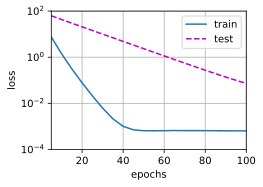

In [12]:
train(lambd=3)
# 很明显的测试集loss降低，在这里再强调一遍，权重衰减的目的是防止过拟合，且这里的从头实现虽然也是在loss中显式地写入一项，但和正问题中的正则化项写入loss还是出于不一样的目的


w的L2范数： 13.71616268157959


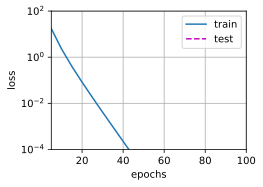

In [14]:
# 权重衰减的做法在深度学习中很常见，因此深度学习框架中也把这个选项集成到了模块当中

def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction="none")
    num_epochs, lr = 100, 0.003

    # 这里对于trainer中的参数更新写法很重要，如果更新规则一致，还是可以像之前一样写：
    #   params=[w,b];trainer(params)
    # 因为此函数中偏置不参与权重衰减，因此分开写，用字典对两个类型的参数进行隔离
    trainer = torch.optim.SGD([
        {"params":net[0].weight,"weight_decay":wd},
        {"params":net[0].bias}
    ],lr=lr)
    animator = Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],ylim=[1e-4,1e2],legend=["train","test"])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if (epoch+1) % 5 == 0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                  evaluate_loss(net,test_iter,loss)))
    print("w的L2范数：",net[0].weight.norm().item())

train_concise(0)

w的L2范数： 0.37835800647735596


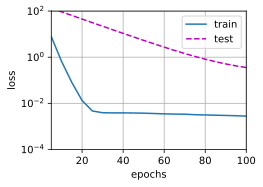

In [15]:
train_concise(3)

### 4.6 暂退法(Dropout)

 - 在暂退法最开始的部分，有一段关于过拟合的论述，在这里解读一下，这里的一个核心概念是**偏差-方差权衡(bias-variance tradeoff)**，这个概念指的意思模型通常需要在偏差和方差这两个性能概念中做出权衡，如果一个模型具有很高的偏差，那他们通常只能表示一小类函数，意思就是模型不具有很强的普适性，它偏离一个通用的状态很远，那么我们可以将这样的模型描述为方差很低，因此表现能力有限，因此在不同的数据样本中可能都会展现出类似的结果，这类模型通常就是线性模型，他的每个权重只负责正相关或者负相关的描述输入和输出之间的关系；但深度神经网络由于网络结构的复杂程度提高，能表示的函数范围也增大，深度神经网络就不再具有极大的偏差，但此时他在方差上就表现的比较大，网络中的特征用d2l书中的说法就是神经网络此时会学习特征之间的交互。
- 从某种程度上来说，前面的**权重衰减是使用参数的范数衡量模型的复杂程度**，文中这里提到还可以**使用平滑性来度量模型的复杂度，平滑性其实和病态程度挂钩，即函数不应该对其输入的微小变化敏感**,如果按照普通的数学知识来衡量矩阵的病态程度我们有很多的手段，但在网络中我们就可以通过这个平滑性的定义入手，即我们可以人为地在网络的内部注入一些随机噪声，如果在训练过程中网络可以无影响地继续工作，就符合平滑性的要求。
- 顺着上面的思路，2014年的时间节点Srivastava等人就在自己的工作中实现了上面的想法：在训练过程中，在计算后续层之前向网络的每一层注入噪声，注入的噪声只会在输入-输出的映射上增强其平滑性，上述方法被称为**暂退法(Dropout)**，暂退法的名字来源于如果从表面上看训练过程中就仿佛丢弃了一些神经元。
- Dropout的关键在于如何在网络中注入噪声，一个实现路径是以一种无偏向的方式注入噪声，注入噪声的每一层的期望等于没有噪声的值；标准的暂退法中，每一个中间活性值$h$以一定的暂退概率$p$由
$h^{'}$替换，基本的替换逻辑如下：
$$
h^{'} = \begin{cases} 0, 概率为p \\ \frac{h}{1-p}, 其他情况 \end{cases}
$$  
    可计算得到此时的期望为原值h
- 考虑上面标准暂退法的做法，其实类似将一些节点在前向传播和反向传播的过程当中剔除掉了，因为一些中间值直接变成0，所以可以想象在前向过程中前面的节点根本不会对后面的计算起到作用；同时因为这些值变成0，反向传播时也不会回传梯度----总结一下，其实就是删除了一些元素的源网络，这样最终输出的值不会过度依赖于网络当中的任何一个元素


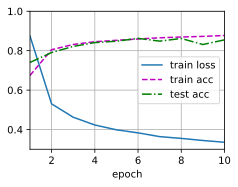

In [20]:
# 本节从零开始实现暂退法
import torch
import torch.nn as nn

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = torch.rand_like(X) > dropout
    return mask * X / (1 - dropout)

X = torch.arange(16, dtype = torch.float32).reshape((2,8))
print(X)
print(dropout_layer(X,0.))
print(dropout_layer(X,0.5))
print(dropout_layer(X,1.))

num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, is_training = True):
        super(Net,self).__init__()
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs,num_hidden1)
        self.lin2 = nn.Linear(num_hidden1,num_hidden2)
        self.lin3 = nn.Linear(num_hidden2,num_outputs)
        self.relu = nn.ReLU()
    def forward(self,X):
        H1 = self.relu(self.lin1(X.reshape((-1,num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1,dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2,dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs,num_outputs,num_hidden1,num_hidden2)

num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction="none")
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr = lr)
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)



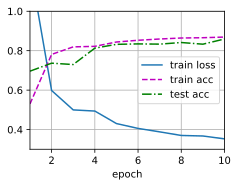

In [21]:
# 下面用简洁的方式实现暂退法
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Dropout(dropout1),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Dropout(dropout2),
    nn.Linear(256,10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

trainer = torch.optim.SGD(net.parameters(),lr = lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 4.7 前向传播、反向传播和计算图

- 前向传播和反向传播是更新参数的关键，本节主要围绕前向和反向中的一些细节展开，同时引入了计算图的概念
- **前向传播**指的是按照顺序计算和存储神经网络中每层的结果，绘制计算图有助于帮助可视化计算中操作符和变量的依赖关系，这里d2l文章中给出了一张反映前向过程的计算图。
- **反向传播**指的是计算神经网络参数梯度的方法，基本的原则是积分中的链式法则，按照前向传播相反的顺序从输出层到输入层遍历网络，反向传播过程中会**存储计算某些参数梯度时所需的任何中间变量**，这里d2l文章中的链式法则公式推导可以自行配合计算图理解。
- 训练神经网络时，前向传播和反向传播相互依赖。对于前向传播，我们沿着依赖的方向遍历计算图并计算其路径上的所有变量。然后将这些用于反向传播，其中的计算顺序与计算图的相反。反向传播中会**重复利用前向传播中存储的中间值**，这样的默认操作带来的影响之一就是需要**保留中间值**，直到反向传播完成。因此**训练过程会比单纯的预测需要更多的显存**，同时中间值的大小与网络层的数量和批量的大小大致呈正比。

### 4.8 数值稳定性和模型初始化

- 这里探讨的数值稳定性和模型的参数初始化挂钩，并不涉及其他网络部分的探讨。我们目前通过一些函数实现了模型参数的初始化，例如nn.init.normal_()之类的方法，但更多的时候其实直接默认了参数以一个固定的方式初始化，但其实初始化对于神经网络的学习起到了至关重要的作用，尤其对于保持数值稳定性至关重要，因此在此节探讨这部分的内容。
- 考虑一个具有多层的深层网络，如果按照反向传播的思路使用链式法则计算浅层网络的参数梯度时，常常会遇到矩阵和向量连乘的情况， 此时就会出现梯度消失和梯度爆炸。
- **梯度消失**常常会出现在类似sigmoid函数的激活函数引入时，sigmoid函数类似于一个阈值函数，在边缘的部分会出现完全激活和完全不激活的情况，这会导致梯度消失，可以看一下下面的例子关于梯度消失的例子。
- **梯度爆炸**同样可能出现在连乘的情况内，如果对于激活值的范围没有限制，就很有可能出现这类情况，这里也可以看下面关于梯度爆炸的例子。
- 解决上面两种极端情况的方式就是进行参数初始化，当然优化时的正则化等手段也可以帮助网络提升稳定性。
- 在之前写过的很多初始化中，我们都通过正态分布来初始化权重，这时最常规的一种；d2l在书中还介绍了一种**Xavier初始化**，其实公式不重要，大致的思路就是让网络当中的每一层输入和输出出于同一个数据分布中，因此就需要在权重和输入值的分布相对独立的情况下按照一定的数学推导来分析前向传播和后向传播时满足统一分布时输入和输出的方差应该如何制定：大致的思路是无法满足前向和反向的两重要求，于是取一个平均值，这个初始化在一些不具有非线性的全连接层中会出现。

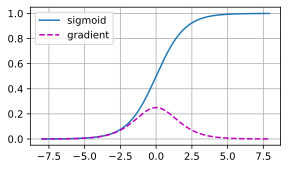

In [28]:
import torch

# 关于梯度消失比较抽象的理解，主要观察激活值位于函数的两侧时，梯度会如何变化：接近于0，此时只要这样的情况出现在连乘的链式法则公式中一次，最后输出的梯度就会变成接近0的情况
x = torch.arange(-8.0,8.0,0.1,requires_grad=True) # 前闭后开
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

plot(x.detach().numpy(),[y.detach().numpy(), x.grad.numpy()], legend = ['sigmoid','gradient'], figsize=(4.5,2.5))

In [ ]:
# 关于梯度爆炸的例子，通过多个矩阵连乘来说明数值的变化情况
M = torch.normal(0,1,size = (4,4))
print("一个矩阵 \n", M)
for i in range(100):
    M = torch.mm(M, torch.normal(0,1,(4,4)))

print("乘上100个矩阵后\n", M) # 此时输出的结果会非常大

一个矩阵 
 tensor([[ 1.1937,  0.4455, -0.8287,  1.4959],
        [ 0.0378,  0.9528,  0.3058, -1.3531],
        [ 0.6745, -1.0217,  0.3877, -1.0989],
        [ 0.7688, -2.6607,  1.0496,  1.0453]])
乘上100个矩阵后
 tensor([[ 2.3431e+23,  3.1661e+23, -2.0739e+24, -4.5386e+23],
        [-1.2998e+23, -1.7564e+23,  1.1505e+24,  2.5178e+23],
        [-1.3663e+23, -1.8462e+23,  1.2093e+24,  2.6465e+23],
        [-3.3832e+22, -4.5714e+22,  2.9945e+23,  6.5533e+22]])


### 4.9 环境和分布偏移

- 这一节更多的是概念和思考，不涉及代码展示
- 最开始的讨论是关于数据分布，比方说在一些问题中，我们能够寻找到的供训练的数据可能在一个分布之内，但模型训练完毕后需要应用在一些数据上做测试，这些数据可能和前面的训练数据处于同一分布(基本上不可能)，也可能拥有一个完全不同的分布，但如果这两个分布之间不存在一定的联系，那么网络最终训练的结果一定是很差的。
- 在上述说的分布偏移情况中，**协变量偏移**是研究最为广泛的：协变量偏移指的是输入的分布可能随时都会发生变化，但标签函数(即条件分布
$P(y|\mathbf{x})$)没有发生改变，这个现象我们是喜欢的，因为输入数据的分布我们无法控制，小样本的训练数据一定会发生和普适分布不同的偏移，但很多任务我们只关心当数据拿到手后的标签数据的分类、数值和正确与否，此时就是协变量偏移的假设大发神威的时刻，我们需要关心的就是如何从不同的输入分布中学习到更为本质的内容，因为在协变量偏移的假设下，我们如果能建立起不同输入分布之间的关系，我们就能够学习到正确的标签数据分布，因为这个条件分布是不变的。
- **标签分布**描述了和协变量偏移相反的情况：我们拿一个d2l中疾病的例子来说明，在一个预测疾病的模型中，我们需要通过当前病人的症状来预测所患的疾病，此时症状就是我们的观察数据
$\mathbf{x}$，而疾病类型就是我们关心的y，但此时我们知道的情况是疾病的患病几率等特征信息是可能随着时间、地区、人种等因素发生改变的，但不变的是什么呢？是当疾病发生后，出现某种症状的概率，这也就是标签偏移的特征，我们假设标签的边缘概率可能会发生改变
- **概念偏移**个人认为是比较少见的，他指的是当标签的定义发生变化，比方说随着时间、地点等的改变，人们对于某些概念的定义会出现偏差
- 有了上面的一些数据分布的概念，我们可以讨论一些具体的场景：首先d2l中介绍的是医学诊断中一个开发检测癌症算法的案例，如果从一些具有偏向性的人群搜集数据，就有可能出现严重的协变量偏移，导致最终的算法无法起到作用；还有一个自动驾驶算法的案例，如果使用游戏渲染引擎制造训练数据可以在算法中获得很好的效果，但实际上可能与真实的汽车数据呈现出完全不同的分布，导致训练得到的算法无法应用在真实场景中...
- 当上述的这些分布偏移出现时，需要找到一些策略应对。首先是协变量偏移纠正，这里用了很大的笔墨来说明如何解决此类现象，总结起来可以用一个公式来说明：
$$
\int \int l(f(\mathbf{x}),y)p(y|\mathbf{x})p(\mathbf{x})d\mathbf{x}dy = \int \int l(f(\mathbf{x}),y)p(y|\mathbf{x})q(\mathbf{x})\frac{p(\mathbf{x})}{q(\mathbf{x})}d\mathbf{x}dy = \int \int l(f(\mathbf{x}),y)p(y|\mathbf{x})q(\mathbf{x})\beta_{i} d\mathbf{x}dy
$$  
这里的
$\beta$ 实际上就表达了一个权重的概念，但这个权重是没办法直接得到的，这里介绍的一个纠正方式就是训练一个分类器来区分从源分布和目标分布中随机抽选的一些变量，对于一些很容易区分的案例，就要按照数值的给定方式给大或者给小权重，这里的推导很简单，可以自行查看书中的讲解
- 概念偏移不太好解决，此时可能重新训练网络以适应数据的变化
- 标签偏移的校正和协变量偏移类似，也是构建分布的损失函数公式，凝练出一个权重函数对其进行修正

### 4.10 实战Kaggle比赛

In [ ]:
import hashlib
import os
import tarfile
import pathlib
import zipfile
import requests

# hashlib中包含生成哈希值的算法；tarfile可以处理.tar的压缩文件；zipfile可以处理.zip文件；pathlib是os.path的替代方案；requests可以发送HTTP请求
